<a href="https://colab.research.google.com/github/BaduA/malaria-diagnosis-ai/blob/main/MalariaDiagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer

In [ ]:
dataset, dataset_info = tfds.load("malaria",with_info=True,as_supervised=True,shuffle_files=True,split=["train"])

In [4]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    length = len(dataset)
    train_data = dataset.take(int(TRAIN_RATIO*length))
    val_test_data = dataset.skip(int(TRAIN_RATIO*length))
    val_data = val_test_data.take(int(VAL_RATIO*length))
    test_data = val_test_data.skip(int(VAL_RATIO*length))
    return train_data, val_data, test_data

In [ ]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

train_data, val_data, test_data = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

print(list(train_data.take(1).as_numpy_iterator()),list(val_data.take(1).as_numpy_iterator()),list(test_data.take(1).as_numpy_iterator()))

# **Visualization**

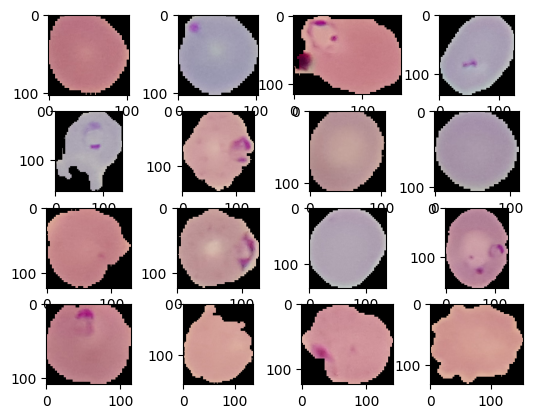

In [6]:
for i, (image,label) in enumerate(train_data.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)


## **Data Preprocessing**

In [7]:
IM_SIZE = 224
def resize_rescale(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255, label

In [8]:
train_data = train_data.map(resize_rescale)

In [9]:
train_data = train_data.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
IM_SIZE = 224
model = tf.keras.Sequential(
    [InputLayer(input_shape = (IM_SIZE,IM_SIZE,3)),

     Conv2D(filters=6,kernel_size=5,strides=1,padding="valid",activation="sigmoid"),
     MaxPool2D(pool_size=2,strides=2),

     Conv2D(filters=16,kernel_size=5,strides=1,padding="valid",activation="sigmoid"),
     MaxPool2D(pool_size=2,strides=2),
     Flatten(),
     Dense(100, activation="sigmoid"),
     Dense(10, activation="sigmoid"),
     Dense(2, activation="sigmoid"),

])
model.summary()
# tf.keras.layers.Conv2D(
#     filters,kernel_size,strides=(1,1),padding="valid",data_format=None,dilation_rate=(1,1),groups=1,activation=None,use_bias=True,kernel_initializer="glorot_uniform",
#     bias_initializer="zeros",kernel_regularizer=None
# )